Getting familiar with all CO and PPH data

In [1]:
import numpy as np
import geopandas as gp
import shapely as sp
import matplotlib.pyplot as plt
import contextily as cx
import cartopy as cp
from datetime import datetime as dt
from datetime import date as dt_date
from datetime import timedelta
import xarray as xr
import pandas as pd
import re
import os
from utils_filter import *
from utils_datetime import *

In [2]:
raw_dir = '~/Downloads'
outlook_raw_location = raw_dir + '/outlooks'
report_raw_location = raw_dir + '/storm_reports'
pph_raw_location = raw_dir + '/pph'
outlook_save_location = 'data/outlooks'
report_save_location = 'data/storm_reports'
pph_save_location = 'data/pph'

# Read in Convective outlooks and filter moderate days

In [3]:
# Read convective outlooks into outlooks
year_list = [[1987, 1991], [1992, 1999], [2000, 2007], [2008, 2015], [2016, 2023]]
outlook_list = []

for years, i in zip(year_list, range(len(year_list))):
    print('reading file ' + str(i) + ', years ' + str(years[0]) + '-' + str(years[1]))
    gdf = gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359')
    outlook_list.append(gdf)

# Concatenate all GeoDataFrames into one
outlooks_original = pd.concat(outlook_list, ignore_index=True)

print('files read')
    
outlooks_original

reading file 0, years 1987-1991
reading file 1, years 1992-1999
reading file 2, years 2000-2007
reading file 3, years 2008-2015
reading file 4, years 2016-2023
files read


,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry
0,198701011200,198701021200,198701010635,C,1,TSTM,CATEGORICAL,-1,"MULTIPOLYGON (((-80.69500 29.36500, -80.68200 ..."
1,198701011500,198701021200,198701011441,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-70.15100 42.90900, -70.14600 42.899..."
2,198701011900,198701021200,198701011849,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-73.73200 39.90700, -73.73200 39.892..."
3,198701021200,198701031200,198701020637,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-124.43300 41.91800, -124.44100 41.9..."
4,198701031200,198701041200,198701020725,C,2,None,None,-1,None
...,...,...,...,...,...,...,...,...,...
366366,202401021200,202401031200,202312310815,C,3,TSTM,CATEGORICAL,8,"POLYGON ((-90.74500 28.71100, -91.08300 28.732..."
366367,202312311300,202401011200,202312311236,C,1,None,None,13,None
366368,202312311630,202401011200,202312311558,C,1,None,None,16,None
366369,202401011200,202401021200,202312311712,C,2,None,None,17,None


In [4]:
# make dates datetime
outlooks = outlooks_original.copy()
outlooks['ISSUE'] = parse_datetime(outlooks['ISSUE'])
outlooks['EXPIRE'] = parse_datetime(outlooks['EXPIRE'])
outlooks['PRODISS'] = parse_datetime(outlooks['PRODISS'])

In [5]:
# reset incicies
outlooks = outlooks.reset_index(drop=True)
outlooks

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry
0,1987-01-01 12:00:00,1987-01-02 12:00:00,1987-01-01 06:35:00,C,1,TSTM,CATEGORICAL,-1,"MULTIPOLYGON (((-80.69500 29.36500, -80.68200 ..."
1,1987-01-01 15:00:00,1987-01-02 12:00:00,1987-01-01 14:41:00,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-70.15100 42.90900, -70.14600 42.899..."
2,1987-01-01 19:00:00,1987-01-02 12:00:00,1987-01-01 18:49:00,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-73.73200 39.90700, -73.73200 39.892..."
3,1987-01-02 12:00:00,1987-01-03 12:00:00,1987-01-02 06:37:00,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-124.43300 41.91800, -124.44100 41.9..."
4,1987-01-03 12:00:00,1987-01-04 12:00:00,1987-01-02 07:25:00,C,2,None,None,-1,None
...,...,...,...,...,...,...,...,...,...
366366,2024-01-02 12:00:00,2024-01-03 12:00:00,2023-12-31 08:15:00,C,3,TSTM,CATEGORICAL,8,"POLYGON ((-90.74500 28.71100, -91.08300 28.732..."
366367,2023-12-31 13:00:00,2024-01-01 12:00:00,2023-12-31 12:36:00,C,1,None,None,13,None
366368,2023-12-31 16:30:00,2024-01-01 12:00:00,2023-12-31 15:58:00,C,1,None,None,16,None
366369,2024-01-01 12:00:00,2024-01-02 12:00:00,2023-12-31 17:12:00,C,2,None,None,17,None


In [6]:
outlooks = fix_month_issue(outlooks)    
outlooks

Fixing for 2002-03-03 12:00:00
Fixing for 2002-07-03 12:00:00
Fixing for 2002-08-03 12:00:00
Fixing for 2002-09-03 12:00:00
Fixing for 2003-05-03 12:00:00
Fixing for 2003-06-03 12:00:00
Fixing for 2003-07-03 12:00:00
Fixing for 2003-08-03 12:00:00
Fixing for 2003-10-03 12:00:00
Fixing for 2003-12-03 12:00:00
Fixing for 2004-01-03 12:00:00
Fixing for 2004-02-03 12:00:00
Fixing for 2004-03-03 12:00:00
Fixing for 2004-04-03 12:00:00
Fixing for 2004-05-03 12:00:00
Fixing for 2004-06-03 12:00:00
Fixing for 2004-07-03 12:00:00
Fixing for 2004-09-03 12:00:00
Fixing for 2004-10-03 12:00:00
Fixing for 2005-04-03 12:00:00
Fixing for 2005-05-03 12:00:00
Fixing for 2005-06-03 12:00:00
Fixing for 2005-07-03 12:00:00
Fixing for 2005-08-03 12:00:00
Fixing for 2005-09-03 12:00:00
Fixing for 2005-12-03 12:00:00
Fixing for 2006-01-03 12:00:00
Fixing for 2006-03-03 12:00:00
Fixing for 2006-04-03 12:00:00
Fixing for 2006-05-03 12:00:00
Fixing for 2006-06-03 12:00:00
Fixing for 2006-07-03 12:00:00
Fixing f

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry
0,1987-01-01 12:00:00,1987-01-02 12:00:00,1987-01-01 06:35:00,C,1,TSTM,CATEGORICAL,-1,"MULTIPOLYGON (((-80.69500 29.36500, -80.68200 ..."
1,1987-01-01 15:00:00,1987-01-02 12:00:00,1987-01-01 14:41:00,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-70.15100 42.90900, -70.14600 42.899..."
2,1987-01-01 19:00:00,1987-01-02 12:00:00,1987-01-01 18:49:00,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-73.73200 39.90700, -73.73200 39.892..."
3,1987-01-02 12:00:00,1987-01-03 12:00:00,1987-01-02 06:37:00,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-124.43300 41.91800, -124.44100 41.9..."
4,1987-01-03 12:00:00,1987-01-04 12:00:00,1987-01-02 07:25:00,C,2,None,None,-1,None
...,...,...,...,...,...,...,...,...,...
366366,2024-01-02 12:00:00,2024-01-03 12:00:00,2023-12-31 08:15:00,C,3,TSTM,CATEGORICAL,8,"POLYGON ((-90.74500 28.71100, -91.08300 28.732..."
366367,2023-12-31 13:00:00,2024-01-01 12:00:00,2023-12-31 12:36:00,C,1,None,None,13,None
366368,2023-12-31 16:30:00,2024-01-01 12:00:00,2023-12-31 15:58:00,C,1,None,None,16,None
366369,2024-01-01 12:00:00,2024-01-02 12:00:00,2023-12-31 17:12:00,C,2,None,None,17,None


In [7]:
# add column with just valid date
outlooks['DATE'] = create_dates(outlooks['EXPIRE'], -1)



In [8]:
# timestamps = outlooks[outlooks['CYCLE'] == 8]
# timestamps[timestamps['PRODISS'].dt.hour == 11]
# acceptable ranges of times for each cycle: prodiss can be all over the place, so we need to just pick a reasonable range of a couple hours based on what issue times we see looking at the -1 cycle forecasts on missing days and what's not super rare in cycle 6 outlooks.
# 6: 4-8Z
# 7: 5-9Z
# 17: 16-19Z
# 8: 6-11Z
acceptable_time_dict = {
    6: [4, 8],
    7: [5, 9],
    17: [16, 19],
    8: [6, 11]
}

In [ ]:
# change cycle to the correct value when there is only -1
outlooks[(outlooks['DAY'] == 1) & (outlooks['DATE'] == dt_date(1987, 2, 14))][0:50]

In [9]:
year = 0
# Iterate only once through the dataset by date
for date in outlooks['DATE'].unique():
    curr_year = date.year
    if curr_year != year:
        print('year', curr_year)
        year = curr_year

    date_outlooks = outlooks[outlooks['DATE'] == date]

    for day, cycle in zip([1, 2, 2, 3], [6, 7, 17, 8]):
        for categorical in [True, False]:
            category_mask = (date_outlooks['CATEGORY'] == 'CATEGORICAL') if categorical else (date_outlooks['CATEGORY'] != 'CATEGORICAL')
            present = ((date_outlooks['DAY'] == day) &
                       (date_outlooks['CYCLE'] == cycle) &
                       category_mask)

            if not present.any():
                # define acceptable hour range
                hour_min, hour_max = acceptable_time_dict[cycle]

                # build mask once
                mask = (
                    (outlooks['DATE'] == date) &
                    (outlooks['DAY'] == day) &
                    (outlooks['CYCLE'] == -1) &
                    ((outlooks['CATEGORY'] == 'CATEGORICAL') if categorical else (outlooks['CATEGORY'] != 'CATEGORICAL')) &
                    (outlooks['PRODISS'].dt.hour >= hour_min) &
                    (outlooks['PRODISS'].dt.hour <= hour_max)
                )

                if mask.any():
                    label = 'categorical' if categorical else 'probabilistic'
                    print(f'changing cycle for {label} outlooks on {date} day {day} cycle {cycle}')
                    outlooks.loc[mask, 'CYCLE'] = cycle


year 1987
changing cycle for categorical outlooks on 1987-01-01 day 1 cycle 6
changing cycle for categorical outlooks on 1987-01-02 day 1 cycle 6
changing cycle for categorical outlooks on 1987-01-03 day 1 cycle 6
changing cycle for probabilistic outlooks on 1987-01-03 day 2 cycle 7
changing cycle for probabilistic outlooks on 1987-01-03 day 2 cycle 17
changing cycle for categorical outlooks on 1987-01-04 day 1 cycle 6
changing cycle for probabilistic outlooks on 1987-01-04 day 2 cycle 7
changing cycle for probabilistic outlooks on 1987-01-04 day 2 cycle 17
changing cycle for categorical outlooks on 1987-01-05 day 1 cycle 6
changing cycle for probabilistic outlooks on 1987-01-05 day 2 cycle 7
changing cycle for probabilistic outlooks on 1987-01-05 day 2 cycle 17
changing cycle for categorical outlooks on 1987-01-06 day 1 cycle 6
changing cycle for probabilistic outlooks on 1987-01-06 day 2 cycle 7
changing cycle for probabilistic outlooks on 1987-01-06 day 2 cycle 17
changing cycle for

In [21]:
# checking if changes worked
outlooks[(outlooks['DAY'] == 1) & (outlooks['DATE'] == dt_date(2009, 5, 28))][0:50]
#['200204190000', '200204200000', '200204210000', '200204250000', '200205060000', '200205250000', '200207310000', '200208130000', '200208300000', '200211090000', '200212230000', '200302030000', '200303250000', '200304140000', '200304150000', '200304160000', '200305100000', '200306250000', '200306280000', '200307270000', '200307280000', '200309030000', '200312280000', '200404020000', '200404140000', '200405230000', '200408090000', '200410140000', '200503300000', '200506060000', '200508030000', '200701040000', '200905280000', '201105210000', '202005240000', '202106130000']

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry,DATE
160999,2009-05-28 13:00:00,2009-05-29 12:00:00,2009-05-28 12:34:00,C,1,TSTM,CATEGORICAL,13,"MULTIPOLYGON (((-95.06100 28.69633, -95.07500 ...",2009-05-28
161000,2009-05-28 13:00:00,2009-05-29 12:00:00,2009-05-28 12:34:00,C,1,0.05,HAIL,13,"MULTIPOLYGON (((-83.15000 42.00900, -83.13100 ...",2009-05-28
161001,2009-05-28 13:00:00,2009-05-29 12:00:00,2009-05-28 12:34:00,C,1,0.15,HAIL,13,"MULTIPOLYGON (((-88.67000 31.20000, -87.53000 ...",2009-05-28
161002,2009-05-28 13:00:00,2009-05-29 12:00:00,2009-05-28 12:34:00,C,1,0.05,WIND,13,"MULTIPOLYGON (((-97.04800 27.15300, -97.04600 ...",2009-05-28
161003,2009-05-28 13:00:00,2009-05-29 12:00:00,2009-05-28 12:34:00,C,1,0.15,WIND,13,"MULTIPOLYGON (((-88.65000 31.27000, -87.54000 ...",2009-05-28
161004,2009-05-28 13:00:00,2009-05-29 12:00:00,2009-05-28 12:34:00,C,1,SLGT,CATEGORICAL,13,"MULTIPOLYGON (((-88.69000 31.23000, -87.55000 ...",2009-05-28
161005,2009-05-28 16:30:00,2009-05-29 12:00:00,2009-05-28 16:21:00,C,1,0.15,WIND,16,"MULTIPOLYGON (((-99.63845 27.64200, -99.65400 ...",2009-05-28
161006,2009-05-28 16:30:00,2009-05-29 12:00:00,2009-05-28 16:21:00,C,1,0.05,HAIL,16,"MULTIPOLYGON (((-82.11227 41.82466, -81.82200 ...",2009-05-28
161007,2009-05-28 16:30:00,2009-05-29 12:00:00,2009-05-28 16:21:00,C,1,0.02,TORNADO,16,"POLYGON ((-86.21000 33.79000, -85.96000 35.550...",2009-05-28
161008,2009-05-28 16:30:00,2009-05-29 12:00:00,2009-05-28 16:21:00,C,1,SLGT,CATEGORICAL,16,"MULTIPOLYGON (((-87.97000 31.50000, -86.79000 ...",2009-05-28


In [22]:
# identify dates with MDT
mod_dates = identify_dates_above_threshold(outlooks, 'MDT')

(array([36., 40., 67., 75., 64., 70., 73., 57., 82., 71., 59., 64., 55.,
        65., 58., 61., 60., 46., 53., 48., 33., 50., 32., 28., 38., 23.,
        21., 20., 12., 10., 17., 13., 13., 10., 14., 27.]),
 array([1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995.,
        1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004.,
        2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
        2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022.,
        2023.]),
 <BarContainer object of 36 artists>)

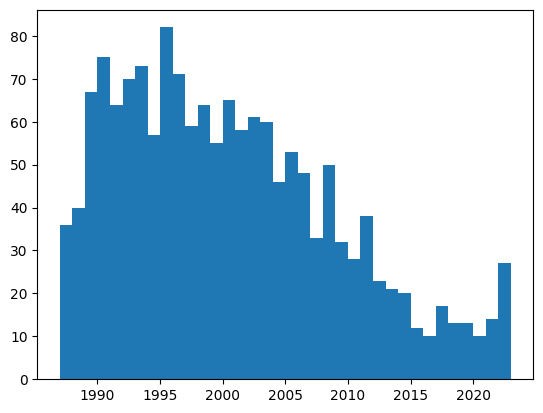

In [23]:
# Plot number of MDT days by year
years_of_mdt = get_years(mod_dates)
plt.hist(years_of_mdt, bins=range(min(years_of_mdt), max(years_of_mdt) + 1, 1))

In [ ]:
# dataframe containing only outlooks for days in which there was a MDT risk
mdt_outlooks = outlooks[outlooks['DATE'].isin(mod_dates)]

# convert datetimes back to strings
outlooks = revert_all_datetimes(outlooks)
mdt_outlooks = revert_all_datetimes(mdt_outlooks)

# save dataframes
outlooks.iloc[:int(len(outlooks)/2)].to_file(outlook_save_location + '/all_outlooks_1.shp')
outlooks.iloc[int(len(outlooks)/2)+1:].to_file(outlook_save_location + '/all_outlooks_2.shp')
mdt_outlooks.to_file(outlook_save_location + '/mdt_outlooks.shp')


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Now read, combine, filter (to mdt), and save PPH data

In [ ]:
hazard_types = ['wind', 'sig_wind', 'hail', 'sig_hail', 'tor', 'sig_tor', 'all_svr', 'all_sig_svr']
for hazard, i in zip(hazard_types, range(len(hazard_types))):
    print('reading in ' + hazard + ' pph')
    if i == 0:
        pph_data = xr.open_dataset(pph_raw_location + '/pper_' + hazard + '_1979_2023.nc')
    else:
        new_data = xr.open_dataset(pph_raw_location + '/pper_' + hazard + '_1979_2023.nc')
        pph_data = xr.merge([pph_data, new_data])




In [ ]:
# select pph data on days with mdt risk
pph_data_mod = pph_data.sel(time=pph_data.time.dt.date.isin(mod_dates.tolist()))

In [ ]:
# save full and moderate pph datasets
pph_data.to_netcdf(pph_save_location + '/all_pph.nc')
pph_data_mod.to_netcdf(pph_save_location + '/mdt_pph.nc')

In [ ]:
pph_data

# Read in, combine, filter, and save raw storm reports

In [ ]:
columns =['STATE', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']
event_types = ['Funnel Cloud', 'Hail', 'Marine Hail', 'Marine Thunderstorm Wind', 'Thunderstorm Wind', 'Tornado', 'Waterspout']




In [ ]:
# read in reports and combine into all_reports
first = True
for file in os.listdir(os.fsencode(report_raw_location)):
    filename = os.fsdecode(file)
    if 'StormEvents_details-ftp_v1.0_d' in filename:
        print('reading' + filename)
        reports = gp.read_file(report_raw_location + '/' + filename)
        if first:
            all_reports = filter_reports(reports, columns, event_types)
            first = False
        else:
            all_reports = all_reports.append(filter_reports(reports, columns, event_types))


In [ ]:
# filter all_reports to get all_reports_mdt
all_reports['DATE'] = parse_datetime_reports(all_reports['BEGIN_DATE_TIME'])
all_reports_mdt = all_reports[all_reports['DATE'].isin(mod_dates.tolist())]



In [ ]:
# save report data
all_reports.to_csv(report_save_location + '/all_reports.csv')
all_reports_mdt.to_csv(report_save_location + '/mdt_reports.csv')
